# First: load imports needed for the project and preparation of the project

In [1]:
# This cell is necessary to use this notebook in google colab
# If you are running this notebook in colab, please change colab to True

import os

colab = True
cwd = os.getcwd()

if colab is True and cwd != "/content/Bsc_Thesis":
  ! git clone https://github.com/SergioTallo/Bsc_Thesis.git
  % cd Bsc_Thesis

print(cwd)

Cloning into 'Bsc_Thesis'...
remote: Enumerating objects: 116, done.
remote: Counting objects: 100% (116/116), done.
remote: Compressing objects: 100% (104/104), done.
remote: Total 116 (delta 71), reused 26 (delta 12), pack-reused 0
Receiving objects: 100% (116/116), 2.89 MiB | 6.56 MiB/s, done.
Resolving deltas: 100% (71/71), done.
/content/Bsc_Thesis
/content


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import torch
import math
from torch import Tensor, float32, sin, cos
import torch.nn as nn
import matplotlib.pyplot as plt
import utils_bsc
import statistics
from tqdm import tqdm

if torch.cuda.is_available():
  device = torch.device('cuda:0')
  print('Device: GPU =', torch.cuda.get_device_name(0))
else:
  device = torch.device('cpu')
  print('Device: CPU')


Device: GPU = Tesla P100-PCIE-16GB


In [3]:
utils_bsc.print_versions()

versions of packages:
Python: 3.7.12
Pandas: 1.3.5
Numpy: 1.21.5
PyTorch: 1.10.0+cu111
Sklearn: 1.0.2


# Data loading and preparation

Now, we should create a dataset with all the data stored in the .csv file

Description of the data:

*   time: Timestamp (YYYY-MM-DD HH:MM:SS)
*   PLN1: Power in the phase 1 (W)
*   PLN2: Power in the phase 2 (W)
*   PLN3: Power in the phase 3 (W)
*   ULL1: Current Voltage between 2 phases (V)
*   ULL2: Current Voltage between 2 phases (V)
*   ULL3: Current Voltage between 2 phases (V)
*   COS_PHI1: Phase shift (Cos)
*   COS_PHI2: Phase shift (Cos)
*   COS_PHI3: Phase shift (Cos)
*   FREQ: Electricity Frequency (Hz)
*   RC_DC: Fault currents
*   RC_AC: Fault currents
*   RC_50Hz: Fault currents
*   RC_150Hz: Fault currents
*   RC_<100Hz: Fault currents
*   RC_100Hz-1kHz: Fault currents
*   RC_>10kHz: Fault currents


In [4]:
dataset = pd.read_csv('data_factory.csv')
dataset.head()

,time,PLN1,PLN2,PLN3,ULL1,ULL2,ULL3,COS_PHI1,COS_PHI2,COS_PHI3,FREQ,RC_DC,RC_AC,RC_50Hz,RC_150Hz,RC_<100Hz,RC_100Hz-1kHz,RC_>1kHz,RC_>10kHz
0,2020-06-01 00:00:00,1141.0819,519.5034,482.9381,398.8613,400.1982,395.6010,0.8091,0.6864,0.4875,49.9927,4.0,91.0,10.0,39.0,36.0,86.0,82.0,7.0
1,2020-06-01 00:01:00,1145.1162,519.1807,491.4436,398.6934,400.1579,395.5431,0.8080,0.6903,0.4904,49.9779,5.0,64.0,7.0,27.0,25.0,60.0,55.0,2.0
2,2020-06-01 00:02:00,1140.9558,743.3837,484.9942,398.4367,400.1205,395.5259,0.8113,0.9274,0.4806,49.9782,4.0,64.0,7.0,27.0,25.0,60.0,55.0,2.0
3,2020-06-01 00:03:00,1151.9409,741.4836,487.4224,398.9800,400.4375,395.8621,0.8249,0.9123,0.4778,49.9850,5.0,66.0,8.0,28.0,25.0,61.0,57.0,2.0
4,2020-06-01 00:04:00,1142.1594,741.9858,486.7629,398.7133,400.3145,395.6446,0.8081,0.9291,0.4552,49.9856,4.0,85.0,11.0,45.0,41.0,75.0,68.0,6.0


Once we have the dataset, we should prepare it. Finding the missing or the NaN values and replace them with suitable values (in this case we use the previous value).

In [5]:
# Replace all mising values with NaN
dataset = dataset.replace(' ', np.nan)
# Search for all the rows with NaN values
nan_values = dataset[dataset.isna().any(axis=1)]
# Print the shape to know how many are there
print(f'Number of rows with NaN values before cleaning: {nan_values.shape[0]}') 

# Fill all NaN values with the previous row value
dataset_clean = dataset.fillna(method='ffill')

# Check that there isn't any NaN values
nan_values = dataset_clean[dataset_clean.isna().any(axis=1)]
# Print the shape to know how many are there
print(f'Number of rows with NaN values after cleaning: {nan_values.shape[0]}') 

#Total number of samples
print(f'Total number of samples: {dataset_clean.shape[0]}')
print(f'Number of features: {dataset_clean.shape[1]}')

Number of rows with NaN values before cleaning: 2546
Number of rows with NaN values after cleaning: 0
Total number of samples: 63360
Number of features: 19


# Distribution of the data

Now we look at the distribution of the different features of the data over different time intervals.
First we take a look of the min and max values, mean and median value and the standard deviation of every feature.

In [6]:
for column in dataset_clean.columns:
  if column == 'time':
    print(column)
    print('Min value: ', dataset_clean[column].min())
    print('Max value: ', dataset_clean[column].max())
    print('')
  else:
    print(column)
    print('Min value: ', dataset_clean[column].min())
    print('Max value: ', dataset_clean[column].max())
    print('Mean value: ', dataset_clean[column].mean())
    print('Median value: ', dataset_clean[column].median())
    print('Standard deviation: ', dataset_clean[column].std())
    print('')

time
Min value:  2020-06-01 00:00:00
Max value:  2020-07-14 23:59:00

PLN1
Min value:  1136.6154
Max value:  26071.959
Mean value:  7185.2709603472795
Median value:  4370.43185
Standard deviation:  5619.401583329123

PLN2
Min value:  330.2979
Max value:  16792.3887
Mean value:  4645.443629026148
Median value:  4504.5791
Standard deviation:  3948.189347661856

PLN3
Min value:  465.1976
Max value:  14512.8389
Mean value:  4081.8074168496946
Median value:  3310.39745
Standard deviation:  3423.479296987532

ULL1
Min value:  384.115
Max value:  418.8481
Mean value:  398.5690919760104
Median value:  399.0723
Standard deviation:  4.60327571313802

ULL2
Min value:  386.556
Max value:  420.7076
Mean value:  400.6287229008857
Median value:  401.09614999999997
Standard deviation:  4.379149353374775

ULL3
Min value:  384.4315
Max value:  418.0959
Mean value:  398.1920267992438
Median value:  398.7023
Standard deviation:  4.1864513722862595

COS_PHI1
Min value:  0.791
Max value:  1.0
Mean value:  0

In [7]:
# Set to True to print the graphs
print_graphs = False

if print_graphs is True:

  for i, column in enumerate(dataset_clean.columns):
    if i > 0:
      # Feature in a weekly interval
      utils_bsc.week_plot(dataset_clean, i, column)
      # Feature in a daily interval (only the values of weekdays between 4:00 and 19:30)
      utils_bsc.daily_plot(dataset_clean, i, column)

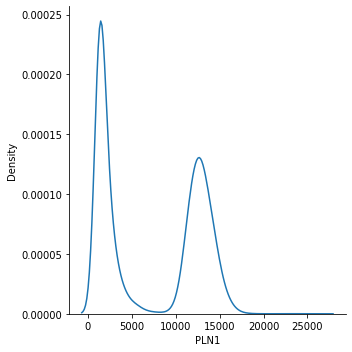

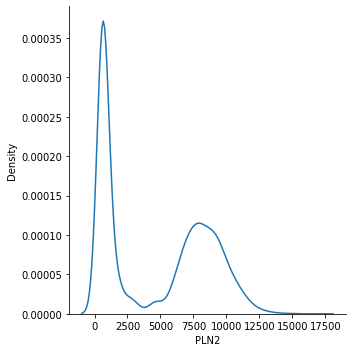

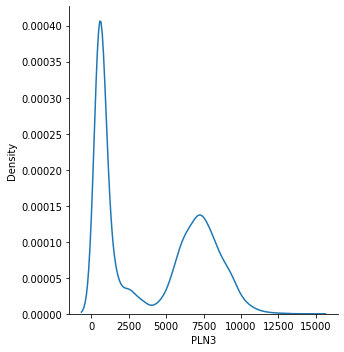

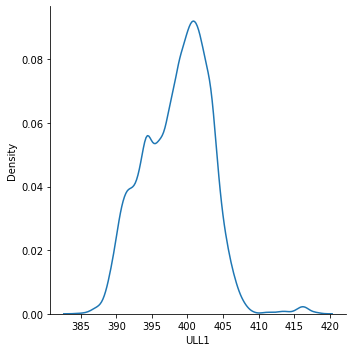

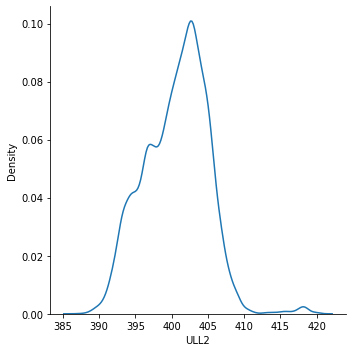

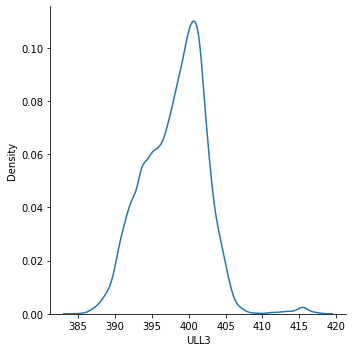

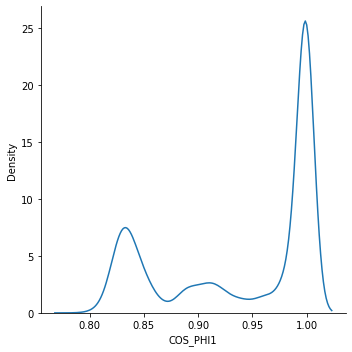

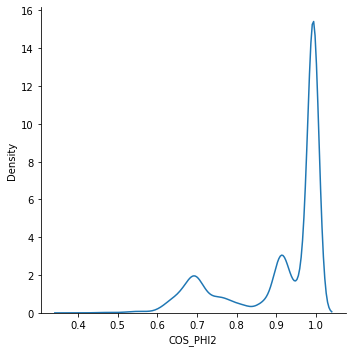

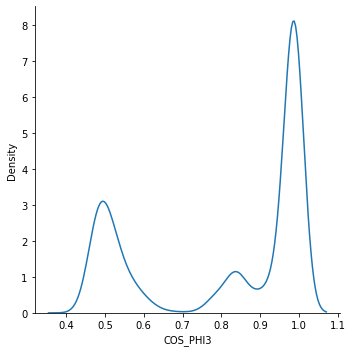

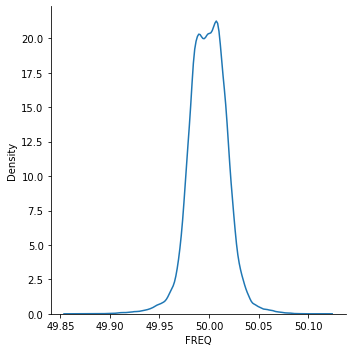

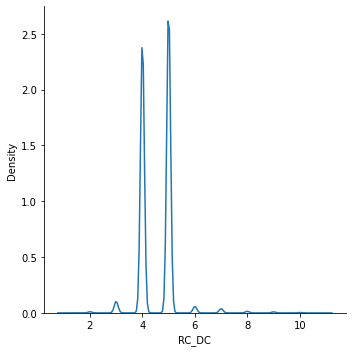

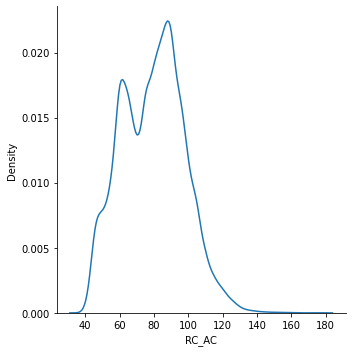

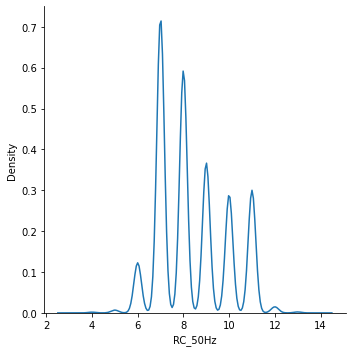

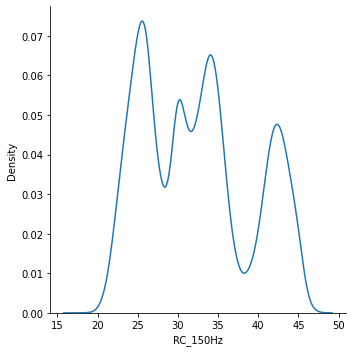

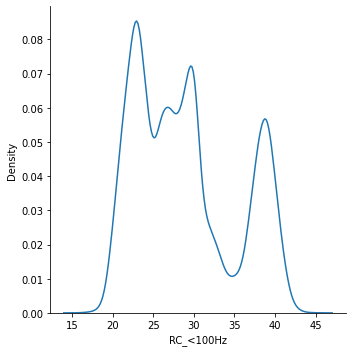

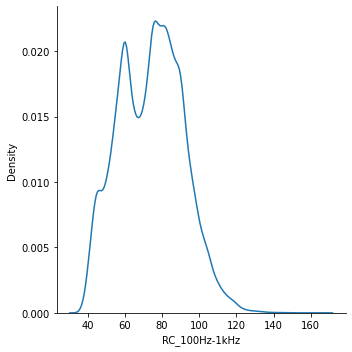

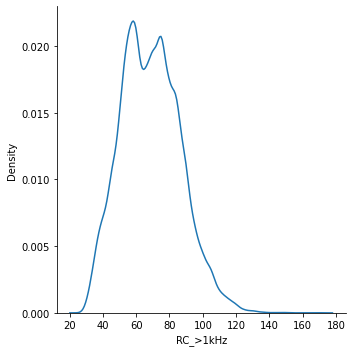

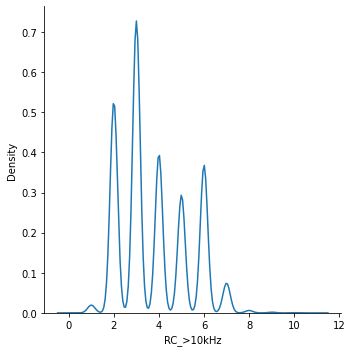

In [11]:
import seaborn as sns

for column in dataset_clean.columns:
  if column != 'time':
    sns.displot(dataset_clean, x=column, kind="kde")

In [ ]:
import datetime

dataset_clean_copy = dataset_clean.copy()

dataset_clean_time = dataset_clean['time']

dataset_clean_time = pd.to_datetime(dataset_clean_time)

time_mask = (dataset_clean_time.dt.hour >= 4)
print(time_mask)

for i in dataset_clean_copy.iloc:
  if time_mask[i.name] is True:
    print(i)

# Dataset normalisation

We divide every valu by the max value of this specific feature to have a value between 0 and 1

100%|██████████| 19/19 [00:08<00:00,  2.25it/s]


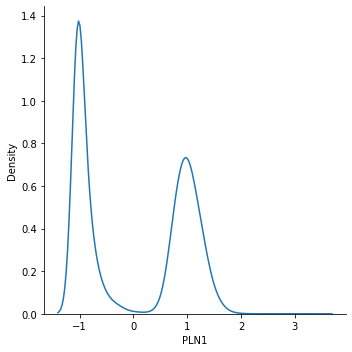

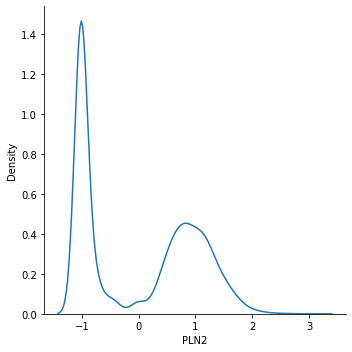

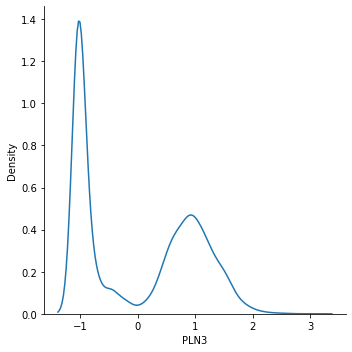

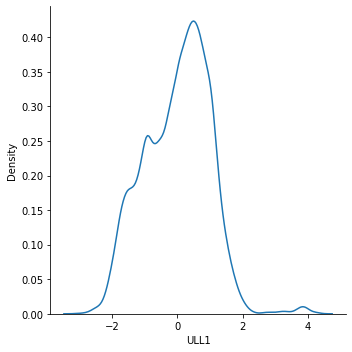

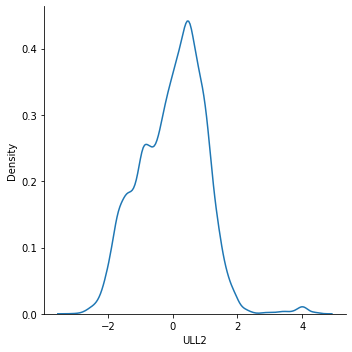

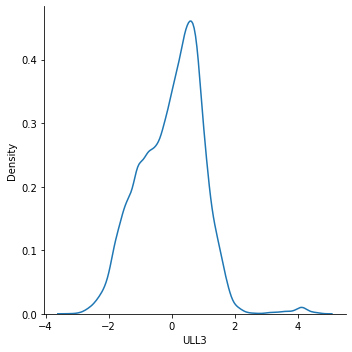

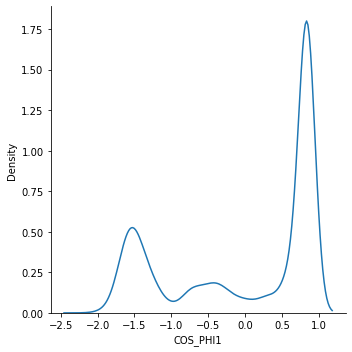

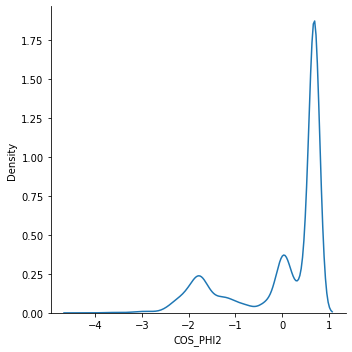

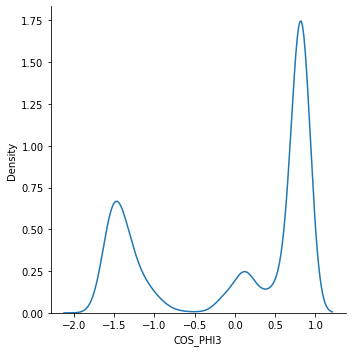

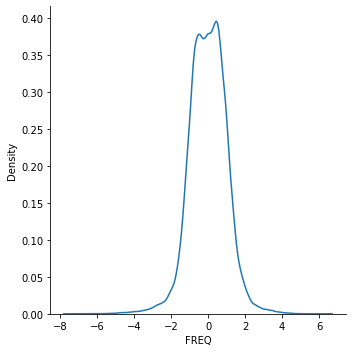

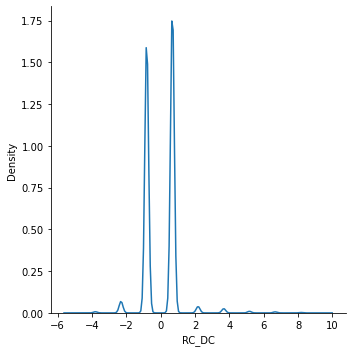

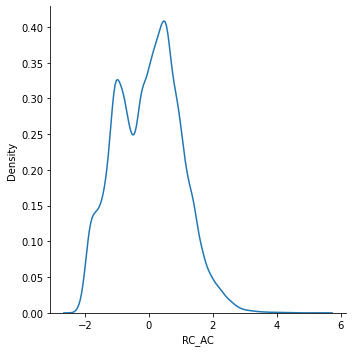

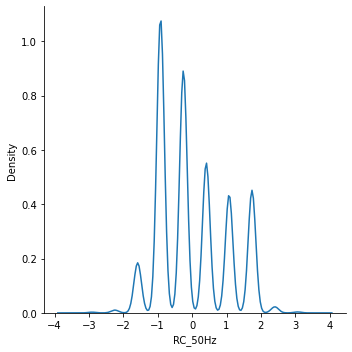

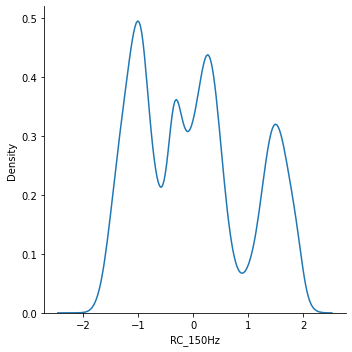

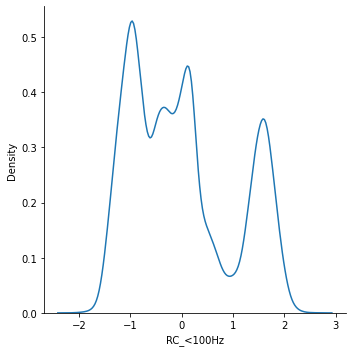

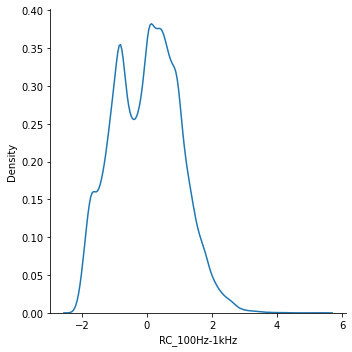

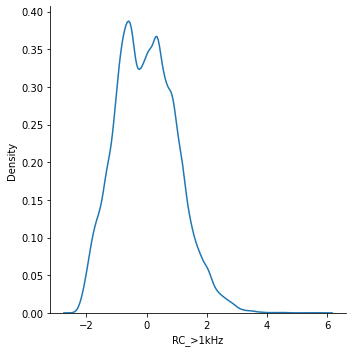

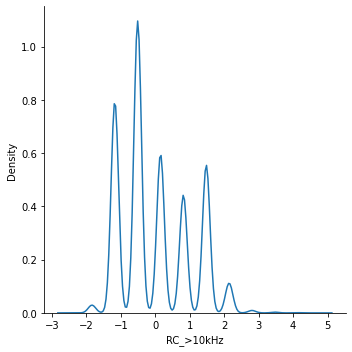

In [16]:
# apply the mean / stddev scaling in Pandas using the .mean() and .std() methods
def normalize_mean_std_dataset(df):
    # copy the dataframe
    df_scaled = df.copy()
    # apply mean / stddev scaling
    for column in tqdm(df_scaled.columns):
      if column != 'time':
        df_scaled[column] = (df[column] - df[column].mean()) / df[column].std()
    return df_scaled

dataset_norm = normalize_mean_std_dataset(dataset_clean)

dataset_norm.head()

for column in tqdm(dataset_norm.columns):
  if column != 'time':
    sns.displot(dataset_norm, x=column, kind="kde")

# Preparation Training and Test set

Once the dataset is prepared, make batches of data,put them togheter in an array and split them into train and test sets.
After looking through the dataset and the features, i decided to takeonly the values with a timestap of a weekday between 4:00 and 19:30. In many of the features in the interval otside those timestamps there i only noise, which can be a sign that the machine is off in that time interval.

In [14]:
# Create 27840 batches of longitud 60

endset = utils_bsc.create_batches(dataset=dataset_norm, batch_size=30, device=device)
    
print(f'\n\n{len(endset)} sequences of longitud {endset[0].shape[0]} with {endset[0].shape[1]} features')

# Spliting into train and test sets

training_data, testing_data = train_test_split(endset, test_size=0.1, random_state=25)

train_set = torch.stack(training_data).float().to(device)
test_set = torch.stack(testing_data).float().to(device)

print(f'length of training set: {train_set.shape[0]}')
print(f'length of test set: {test_set.shape[0]}')

100%|██████████| 32/32 [00:16<00:00,  2.00it/s]


AttributeError: ignored

# Create a Baseline Model

I am taking the median of all features to create an statistical baselinemodel. I will use this baseline model to compare the results of the actual model with it. Everything that works better than this baseline model could be an improvement.

!!!!Last step as prediction!!!!

In [ ]:
criterion = nn.MSELoss()

losses = []

for i in range(1, len(train_set)):
  loss = criterion(train_set[i], train_set[i - 1])
  losses.append(float(loss))

print("Mean Loss of baselinemodel: ", np.mean(losses))
print("Standard deviation Loss of baselinemodel: ", np.std(losses))


Mean Loss of baselinemodel:  0.9703539133329461
Standard deviation Loss of baselinemodel:  0.5991845827967649


In [ ]:
class ANN_relu(nn.Module):

    def __init__(self, D_in, D_out, device):
        super(ANN_relu, self).__init__()
        self.linear1 = nn.Linear(D_in, 128).to(device)
        self.linear2 = nn.Linear(128, 128).to(device)
        self.linear3 = nn.Linear(128, D_out).to(device)

    def forward(self, x):
        x = self.linear1(x)
        x = torch.relu(x)
        x = self.linear2(x)
        x = torch.relu(x)
        x = self.linear3(x)
        
        return x

# This function trains the model for one epoch
# Nothing to do here
def train(model, device, train_set, optimizer, n_epochs):
    model.train()

    for e in range(1, n_epochs +1):
      print(f'\nEpoch {e}:')

      losses = []

      for batch_idx in tqdm(range(len(train_set))):
        
        batch = train_set[batch_idx]

        for i in range(len(batch) - 1):
          optimizer.zero_grad()
          data, target = batch[i].to(device), batch[i + 1].to(device)
          output = model(data)
          loss = criterion(output, target)
          losses.append(float(loss))
          loss.backward()
          optimizer.step()
      
      print("\nMean Loss of Model FFN: ", np.mean(losses))

model_FFN = ANN_relu(18, 18, device)

n_epochs = 10
lr=0.01

# Define Loss, Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_FFN.parameters(), lr=lr)

train_FFN = False
if train_FFN is True:
  train(model_FFN, device, train_set, optimizer, n_epochs)

# RNN Model

We train before a standard RNN and see which results we can expected with a small and easy solution.
I am using this template (https://github.com/gabrielloye/RNN-walkthrough/blob/master/main.ipynb) and make changes using it as a base.

1) torch.nn.RNN (https://pytorch.org/docs/stable/generated/torch.nn.RNN.html)

Parameters
* input_size – The number of expected features in the input x
* hidden_size – The number of features in the hidden state h
* num_layers – Number of recurrent layers. E.g., setting num_layers=2 would mean stacking two RNNs together to form a stacked RNN, with the second RNN taking in outputs of the first RNN and computing the final results. Default: 1
* nonlinearity – The non-linearity to use. Can be either 'tanh' or 'relu'. Default: 'tanh'
* bias – If False, then the layer does not use bias weights b_ih and b_hh. Default: True
* batch_first – If True, then the input and output tensors are provided as (batch, seq, feature) instead of (seq, batch, feature). Note that this does not apply to hidden or cell states. See the Inputs/Outputs sections below for details. Default: False
* dropout – If non-zero, introduces a Dropout layer on the outputs of each RNN layer except the last layer, with dropout probability equal to dropout. Default: 0
* bidirectional – If True, becomes a bidirectional RNN. Default: False

2) torch.nn.Linear (https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)

Parameters
* in_features – size of each input sample
* out_features – size of each output sample
* bias – If set to False, the layer will not learn an additive bias. Default: True


In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers, device, batch_first = True, dropout = 0):
        super(RNN, self).__init__()

        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.device = device

        #Defining the layers
        # RNN Layer
        self.rnn = nn.RNN(input_size = input_size, hidden_size = hidden_dim, num_layers = n_layers, batch_first = batch_first, dropout = dropout)   
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_size)
    
    def forward(self, x):
        
        batch_size = x.size(0)

        # Initializing hidden state for first input using method defined below
        hidden = self.init_hidden(batch_size).to(self.device)

        # Passing in the input and hidden state into the model and obtaining outputs
        out, hidden = self.rnn(x, hidden)
        
        # Reshaping the outputs such that it can be fit into the fully connected layer
        out = out.contiguous().view(-1, self.hidden_dim)
        out = self.fc(out)
        
        return out, hidden
    
    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        # We'll send the tensor holding the hidden state to the device we specified earlier as well
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        return hidden

In [ ]:
# Instantiate the model with hyperparameters

model_rnn = RNN(input_size = 18,
                output_size = 18,
                hidden_dim = 36,
                n_layers = 1,
                batch_first = True,
                dropout = 0,
                device = device)

# We'll also set the model to the device that we defined earlier (default is CPU)
model_rnn = model_rnn.to(device)

# Define hyperparameters
n_epochs = 10
lr=0.01

# Define Loss, Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_rnn.parameters(), lr=lr)

losses = []

# Training Run
for epoch in range(1, n_epochs + 1):

  model_rnn.train()

  optimizer.zero_grad() # Clears existing gradients from previous epoch

  for i in tqdm(range(len(train_set) -1)):

    output, hidden = model_rnn(train_set[i].unsqueeze(0))

    loss = criterion(output, train_set[i + 1])
    losses.append(float(loss))
    loss.backward() # Does backpropagation and calculates gradients
    optimizer.step() # Updates the weights accordingly

  print('\nEpoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
  print(f'Mean Loss: {np.mean(losses)} \n')

100%|██████████| 25919/25919 [00:48<00:00, 529.25it/s]



Epoch: 1/10............. Loss: 2540.064525383316 



100%|██████████| 25919/25919 [00:49<00:00, 526.97it/s]



Epoch: 2/10............. Loss: 3277.6794208500173 



100%|██████████| 25919/25919 [00:48<00:00, 530.45it/s]



Epoch: 3/10............. Loss: 3502.7382821728957 



100%|██████████| 25919/25919 [00:48<00:00, 529.95it/s]



Epoch: 4/10............. Loss: 3547.7315658506886 



100%|██████████| 25919/25919 [00:49<00:00, 528.30it/s]



Epoch: 5/10............. Loss: 3466.231752442679 



100%|██████████| 25919/25919 [00:49<00:00, 525.73it/s]



Epoch: 6/10............. Loss: 3410.8553041164996 



100%|██████████| 25919/25919 [00:48<00:00, 529.63it/s]



Epoch: 7/10............. Loss: 3250.5303340757787 



100%|██████████| 25919/25919 [00:48<00:00, 529.94it/s]



Epoch: 8/10............. Loss: 3051.6047038347583 



100%|██████████| 25919/25919 [00:48<00:00, 530.09it/s]



Epoch: 9/10............. Loss: 2961.5740359454912 



100%|██████████| 25919/25919 [00:49<00:00, 527.69it/s]


Epoch: 10/10............. Loss: 2823.11706335036 



In [ ]:
# Show results of the loss function

fig = plt.figure()

ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

ax.plot(losses)
ax.set_title("Mean Squared Error")
fig.canvas.draw()

# Transformer Model settings

Now, we define a class with the transformer model that we are going to use:

Using the already written pytorch library for Transformers:

1) torch.nn.TransformerEncoderLayer (https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html)

*   d_model –> the number of expected features in the input (required).
*   nhead –> the number of heads in the multiheadattention models (required).
*   dropout –> the dropout value (default=0.1).
*   activation –> the activation function of the intermediate layer, can be a string (“relu” or “gelu”) or a unary callable. (default: relu)
*   layer_norm_eps –> the eps value in layer normalization components (default=1e-5).
*   batch_first –> If True, then the input and output tensors are provided as (batch, seq, feature). (default: False)
*   norm_first –> if True, layer norm is done prior to attention and feedforward operations, respectivaly. Otherwise it’s done after. (default: False (after))

2) torch.nn.TransformerDecoderLayer

* d_model –> the number of expected features in the input (required).
* nhead –> the number of heads in the multiheadattention models (required).
* dim_feedforward –> the dimension of the feedforward network model (default=2048).
* dropout –> the dropout value (default=0.1).
* activation –> the activation function of the intermediate layer, can be a string (“relu” or “gelu”) or a unary callable. Default: relu
* layer_norm_eps –> the eps value in layer normalization components (default=1e-5).
* batch_first –> If True, then the input and output tensors are provided as (batch, seq, feature). Default: False.
* norm_first –> if True, layer norm is done prior to self attention, multihead attention and feedforward operations, respectivaly. Otherwise it’s done after. Default: False (after).

3) torch.nn.TransformerEncoder

* encoder_layer –> an instance of the TransformerEncoderLayer() class (required).
* num_layers –> the number of sub-encoder-layers in the encoder (required).
* norm –> the layer normalization component (optional).


4) torch.nn.TransformerDecoder

* decoder_layer – an instance of the TransformerDecoderLayer() class (required).
* num_layers – the number of sub-decoder-layers in the decoder (required).
* norm – the layer normalization component (optional).


In [ ]:
def positional_encoding(seq_len: int, dim_model: int, device):
    
    # Tensor with the positions of every sequence element (0 to seq_len)
    pos = torch.arange(seq_len, dtype=float32, device=device).reshape(1, -1, 1)
    
    # Tensor with the positions of every feature in the sequence (0 to dim_model)
    dim = torch.arange(dim_model, dtype=float32, device=device).reshape(1, 1, -1)

    phase = pos / (1e4 ** (torch.div(dim, dim_model, rounding_mode='floor')))

    position_encoding = torch.where(dim.long() % 2 == 0, sin(phase), cos(phase))

    return position_encoding.to(device)


class Transformer(nn.Module):
    def __init__(self, feature_size, output_size, num_encoder_layers, num_heads, num_decoder_layers, device, debug: bool = False, dropout: float =0.1, batch_first: bool = False):
        super(Transformer, self).__init__()
        
        encoder_layer = nn.TransformerEncoderLayer(d_model= feature_size, nhead= num_heads, dropout=dropout, device=device, batch_first=batch_first)
        decoder_layer = nn.TransformerDecoderLayer(d_model= feature_size, nhead= num_heads, dropout=dropout, device=device, batch_first=batch_first)
        
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers= num_encoder_layers)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers= num_decoder_layers)

        self.output_size = output_size
        self.device = device
        self.debug = debug

    def generate_square_mask(self, dim):
        return torch.triu(torch.ones(dim, dim) * float('-inf'), diagonal=1).to(self.device)
        
    def forward (self, src):
        
        mask = self.generate_square_mask(len(src))
        if self.debug is True:
            print('mask creation: ok')

        src_pos = src + positional_encoding(src.shape[1], src.shape[2], self.device)
        if self.debug is True:
            print('Pos encoder (encoder): ok')

        output = self.encoder (src, mask)
        if self.debug is True:
            print('encoder pass: ok')
        
        output = self.decoder (src_pos, output, mask)
        if self.debug is True:
            print('decoder pass: ok')
        return output

We should define an optimizer too.
For this, we use the pytorch library:

* SGD –> Stochastic gradient descent.

1) torch.optim.SDG (https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD)

* params (iterable) – iterable of parameters to optimize or dicts defining parameter groups
* lr (float) – learning rate
* momentum (float, optional) – momentum factor (default: 0)
* weight_decay (float, optional) – weight decay (L2 penalty) (default: 0)
* dampening (float, optional) – dampening for momentum (default: 0)
* nesterov (bool, optional) – enables Nesterov momentum (default: False)

In [ ]:
# Initialize Transformer Model and Optimizer

model = Transformer (num_encoder_layers=3,
                     num_decoder_layers=3,
                     feature_size=18,
                     output_size=18,
                     num_heads=3,
                     device = device,
                     batch_first=False,
                     debug=False)

print('Setup model Ok')

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

print('Setup optimizer Ok')

train_transformer = True

if train_transformer is True:

  # List to keep track of the losses
  loss_list = []

  epochs = 10

  out = []

  for e in range(epochs):
    print('Epoch: ', e + 1)

    for i in tqdm(range(len(train_set))):
      Transformer.train()

      # Initialize optimizer gradients
      optimizer.zero_grad()

      batch = train_set[i].unsqueeze(0)
      net_out = model.forward(batch)
      out.append(net_out)
      loss = torch.mean((net_out - batch) ** 2).to(device)

      loss.backward()
      optimizer.step()

      loss_list.append(loss.item())

print(loss_list)

In [ ]:
# Show results of the loss function

fig = plt.figure()

ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

ax.plot(loss_list)
ax.set_title("Mean Squared Error")
fig.canvas.draw()

Ideas, things to remember, to search, etc...

reconstruction, vergelich mit base line model